In [15]:
# Required packages

import numpy as np
import pandas as pd
from scipy.stats import norm

from numpy import random
import datetime
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from fitter import Fitter, get_common_distributions, get_distributions

## CUSUM Detector Documentation

### Introduction

The CusumDetector class is designed to detect change points in time series data using the Probabilistic Cumulative Sum (CUSUM) method. Change point detection is crucial in various fields such as fintech, e-commerce, and environmental monitoring, where identifying shifts in data trends can indicate significant events or anomalies.

### Dataset Overview
The dataset used with the CusumDetector class should be a time series with observations recorded at regular intervals. It typically includes:

Time column: A column representing the time or date of each observation.
Metric columns: One or more columns representing different metrics or variables being monitored over time.

Here is a timeseries dataset provided to us by our industrial partner Wise.

In [16]:
file_path = r'C:\Users\General\Desktop\CAPSTONE\Datasets\timeseries1.csv'
# C:\Users\General\Desktop\MSc Data Science\CAPSTONE\Datasets

a = pd.read_csv(file_path)
a

date    value1    value2
0    01-01-2022 -0.601368  0.441227
1    02-01-2022  0.319782 -0.330870
2    03-01-2022 -1.592994  2.430771
3    04-01-2022  0.440475 -0.252092
4    05-01-2022 -0.019638  0.109610
..          ...       ...       ...
295  23-10-2022 -3.760809 -2.509073
296  24-10-2022 -3.525656 -1.104999
297  25-10-2022 -0.737416 -2.176203
298  26-10-2022 -2.551858 -1.653917
299  27-10-2022  0.558199 -2.506310

[300 rows x 3 columns]

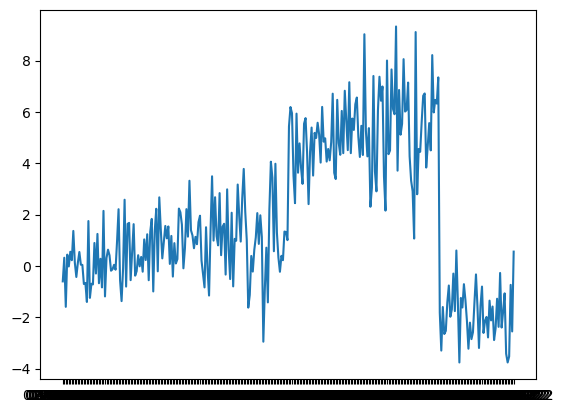

In [17]:
plt.plot(a['date'], a['value1'])
plt.show()

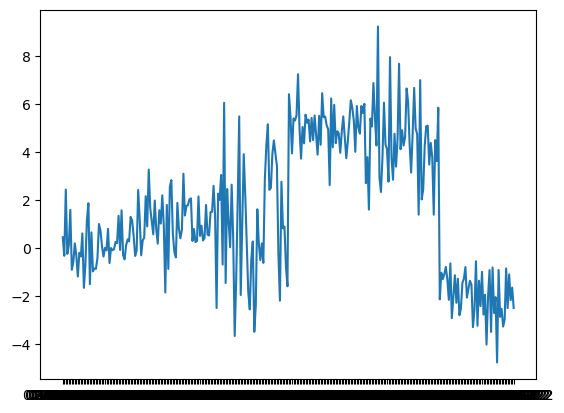

In [18]:
plt.plot(a['date'], a['value2'])
plt.show()

### Design Considerations

The CusumDetector class was designed with the following considerations:

- Warm-up Period (t_warmup):
A certain number of initial observations are used to estimate the parameters (mean and standard deviation) of the time series. This period is crucial to avoid false positives in the early stages of detection.
- Probability Limit (p_limit):
The threshold probability for detecting a change point. Lower values increase sensitivity, detecting smaller changes, while higher values reduce false positives.
- Handling Multiple Metrics:
The class processes each metric separately, allowing for independent detection of change points in different metrics. This is crucial in multi-metric monitoring scenarios where changes in one metric do not necessarily imply changes in another.

In [21]:
class CusumDetector:
    """
    A class used to detect change points in a time series using the Probabilistic Cumulative Sum (CUSUM) method.

    Attributes:
    -----------
    t_warmup : int
        The number of initial observations to consider as the warm-up period.
    p_limit : float
        The threshold probability for detecting a change point.

    Methods:
    --------
    predict_next(y)
        Predicts the probability of a change point and whether a change point is detected for the next observation.
    extract_prob_checkpoint(y)
        Processes the entire series to extract probabilities and change points.
    plot_checkpoint(df, column)
        Plots the time series and marks the detected change points.
    process_single_column(df, column)
        Processes a single column in a DataFrame to detect and plot change points.
    plot_cusum(df, columns)
        Processes multiple columns in a DataFrame to detect and plot change points.
    """

    def __init__(self, t_warmup=30, p_limit=0.01):
        """
        Initializes the CusumDetector with a specified warm-up period and probability limit.

        Parameters:
        -----------
        t_warmup : int, optional
            The number of initial observations to consider as the warm-up period (default is 30).
        p_limit : float, optional
            The threshold probability for detecting a change point (default is 0.01).
        """
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        self._reset()
        
    def predict_next(self, y):
        """
        Predicts the probability of a change point and whether a change point is detected for the next observation.

        Parameters:
        -----------
        y : float
            The next observation in the time series.

        Returns:
        --------
        tuple
            A tuple containing the probability of no change point (1-prob) and a boolean indicating if a change point is detected.
        """
        self._update_data(y)
        
        if self.current_t == self._t_warmup:
            self._init_params()
            
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            
            if is_changepoint:
                self._reset()
                
            return (1-prob), is_changepoint
        
        else:
            return 0, False
        
    def _reset(self):
        """
        Resets the internal state of the detector.
        """
        self.current_t = 0
        self.current_obs = []
        self.current_mean = None
        self.current_std = None
        
    def _update_data(self, y):
        """
        Updates the internal data with the new observation.

        Parameters:
        -----------
        y : float
            The new observation.
        """
        self.current_t += 1
        self.current_obs.append(y)

    def _init_params(self):
        """
        Initializes the parameters (mean and standard deviation) using the observations collected during the warm-up period.
        """
        self.obs = pd.Series(self.current_obs)
        f = Fitter(self.obs, distributions=["norm"])
        f.fit()
        self.current_mean = f.fitted_param["norm"][0]
        self.current_std = f.fitted_param["norm"][1]
        
    def _check_for_changepoint(self):
        """
        Checks if a change point is detected based on the cumulative sum and the initialized parameters.

        Returns:
        --------
        tuple
            A tuple containing the probability of no change point (prob) and a boolean indicating if a change point is detected.
        """
        standardized_sum = (np.sum(self.current_obs) - (self.current_t * self.current_mean)) / (self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum))
        
        return prob, prob < self._p_limit
    
    def _get_prob(self, y):
        """
        Computes the probability based on the standardized sum.

        Parameters:
        -----------
        y : float
            The standardized sum.

        Returns:
        --------
        float
            The computed probability.
        """
        p = norm.cdf(np.abs(y))
        prob = 2 * (1 - p)
        
        return prob
    
    def extract_prob_checkpoint(self, y):
        """
        Processes the entire series to extract probabilities and change points.

        Parameters:
        -----------
        y : array-like
            The time series data.

        Returns:
        --------
        tuple
            A tuple containing an array of probabilities and an array of detected change point indices.
        """
        self._reset()
        ret_val = [self.predict_next(y[i]) for i in range(len(y))]
        cps = np.where(list(map(lambda x: x[1], ret_val)))[0]
        probs = np.array(list(map(lambda x: x[0], ret_val)))
        
        return probs, cps
        
    def plot_checkpoint(self, df, column):
        """
        Plots the time series and marks the detected change points.

        Parameters:
        -----------
        df : DataFrame
            The DataFrame containing the time series data.
        column : str
            The column name of the time series data.

        Returns:
        --------
        Series
            The dates of the detected change points.
        """
        self._reset()
        
        date_format = "%d-%m-%Y"  # Adjust this format as per your date format
        
        if not pd.api.types.is_datetime64_any_dtype(df.iloc[:, 0]):
            try:
                dates = pd.to_datetime(df.iloc[:, 0], format=date_format)
            except ValueError:
                dates = df.index  # If conversion fails, keep time as is
        else:
            dates = df.iloc[:, 0]
        
        y = df[column]
        
        outs = [self.predict_next(y[i]) for i in range(len(y))]
        
        cps = np.where(list(map(lambda x: x[1], outs)))[0]
        
        ret_date = dates.iloc[cps]
        
        plt.figure(figsize=(18, 9))
        plt.plot(dates, y, lw=0.75, label="Data", color="blue")
        
        # Plot detected changepoints
        [plt.axvline(dates.iloc[cp], color="red", linestyle="dashed", lw=2) for cp in cps]

        plt.grid(alpha=0.75, linestyle="dotted", lw=2)
        plt.legend()
        plt.title("CUSUM Results")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.show()
        
        return ret_date
        
    def process_single_column(self, df, column):
        """
        Processes a single column in a DataFrame to detect and plot change points.

        Parameters:
        -----------
        df : DataFrame
            The DataFrame containing the time series data.
        column : str
            The column name of the time series data.

        Returns:
        --------
        list
            A list containing the dates of the detected change points.
        """
        self._reset()
        return [self.plot_checkpoint(df, column)]
    
    def plot_cusum(self, df, columns):
        """
        Processes multiple columns in a DataFrame to detect and plot change points.

        Parameters:
        -----------
        df : DataFrame
            The DataFrame containing the time series data.
        columns : list of str
            The list of column names of the time series data.

        Returns:
        --------
        dict
            A dictionary with column names as keys and lists of dates of detected change points as values.
        """
        results = {}
        for column in columns:
            results[column] = self.process_single_column(df, column)
        return results


In [22]:
# Initialize CUSUM detector
test = CusumDetector()

2024-08-07 10:51:39.755 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-08-07 10:51:39.786 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-08-07 10:51:39.817 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-08-07 10:51:39.847 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-08-07 10:51:39.876 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


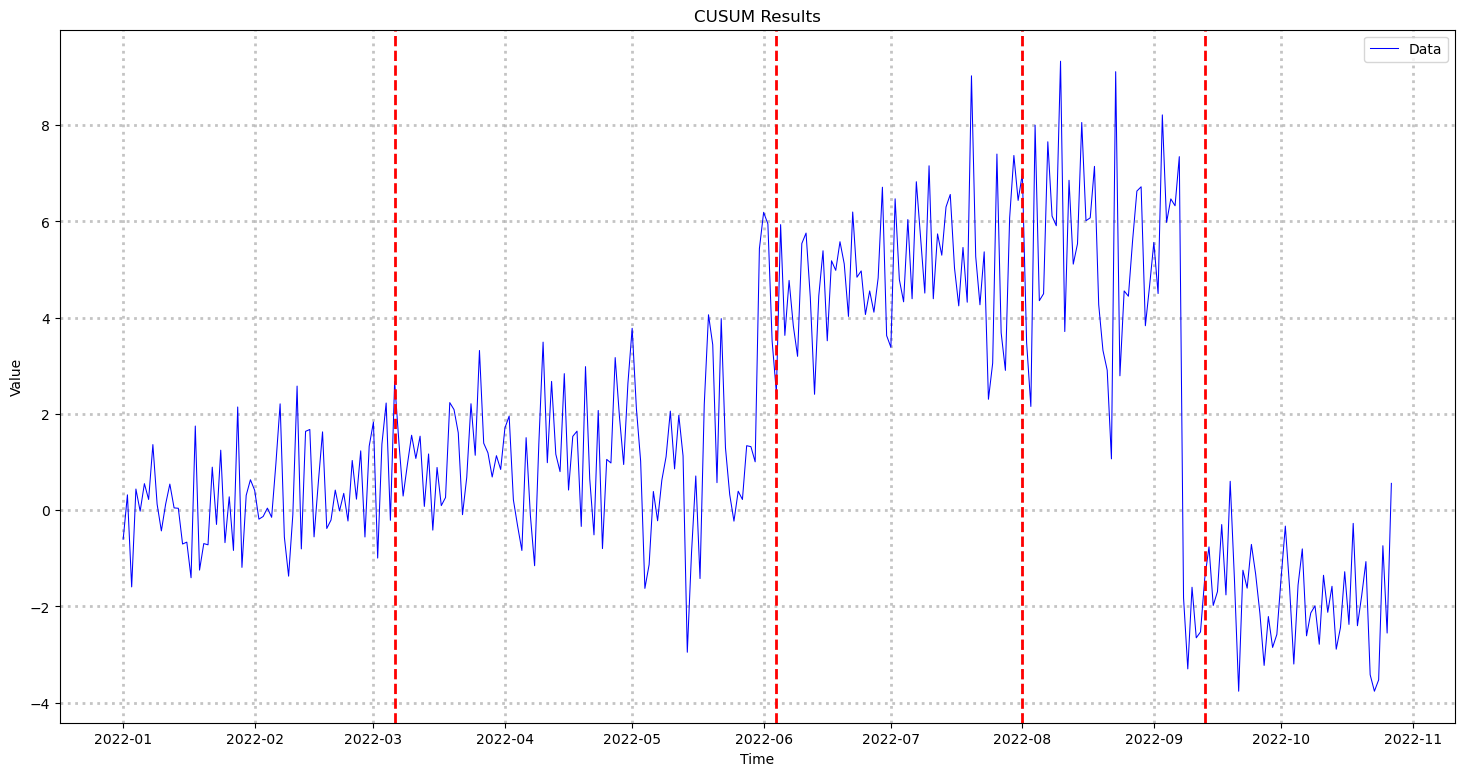

64    2022-03-06
154   2022-06-04
212   2022-08-01
255   2022-09-13
Name: date, dtype: datetime64[ns]

In [23]:
test.plot_checkpoint(a, 'value1')

2024-08-07 10:51:40.144 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-08-07 10:51:40.174 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-08-07 10:51:40.208 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-08-07 10:51:40.237 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-08-07 10:51:40.268 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


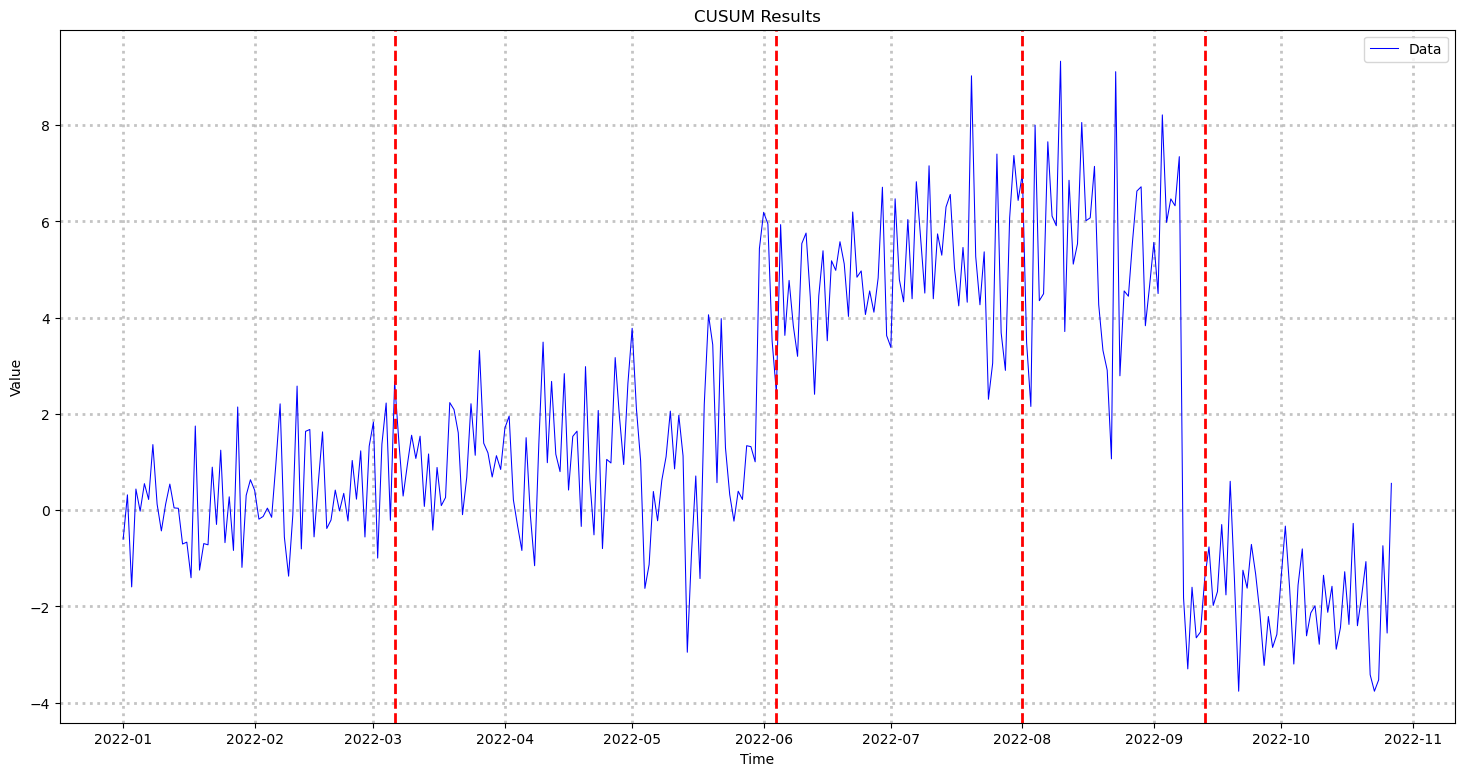

2024-08-07 10:51:40.527 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-08-07 10:51:40.549 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-08-07 10:51:40.583 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=18.893876)
2024-08-07 10:51:40.614 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=43.929834)


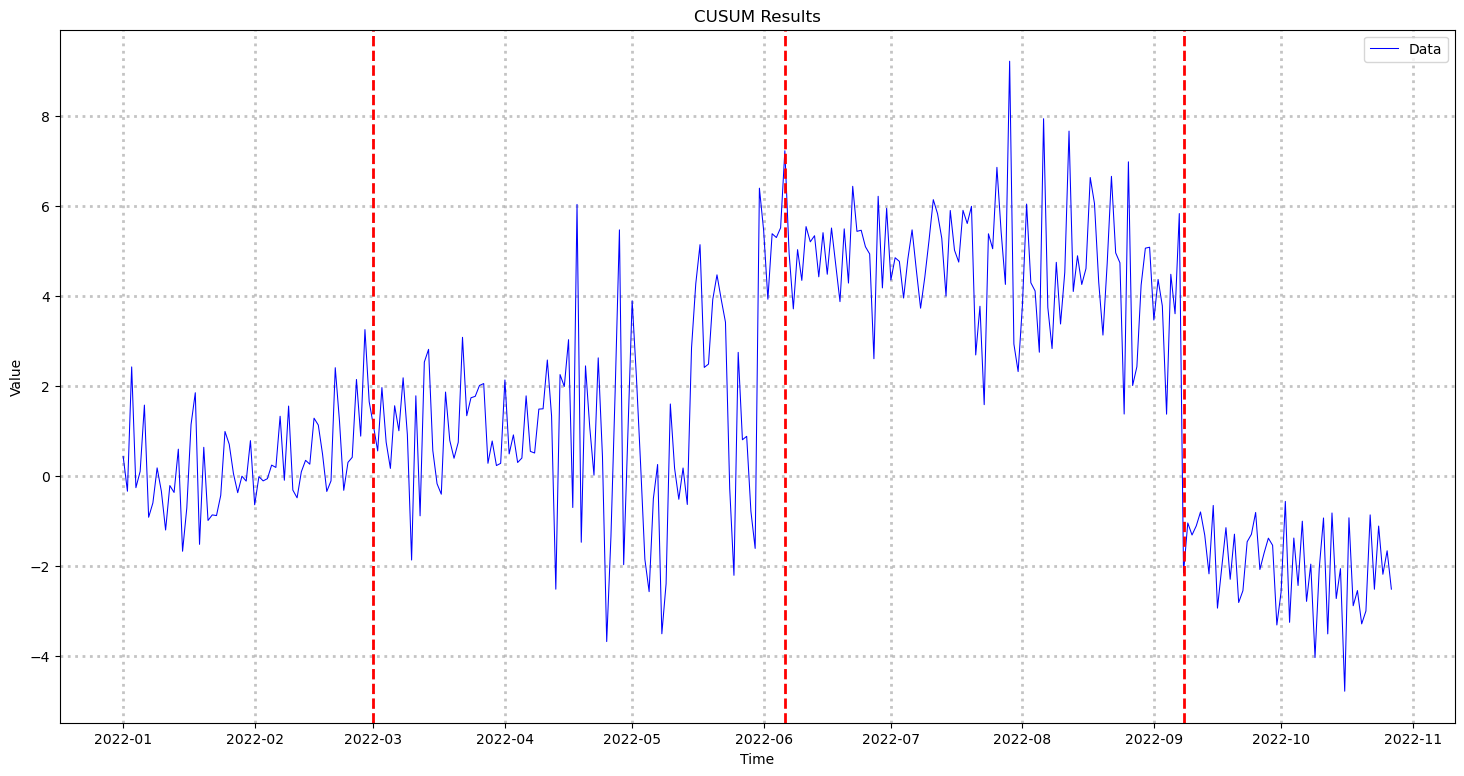

Results for value1: [64    2022-03-06
154   2022-06-04
212   2022-08-01
255   2022-09-13
Name: date, dtype: datetime64[ns]]
Results for value2: [59    2022-03-01
156   2022-06-06
250   2022-09-08
Name: date, dtype: datetime64[ns]]


In [24]:
# Process multiple columns
results = test.plot_cusum(a, ['value1', 'value2'])
for column, result in results.items():
    print(f"Results for {column}: {result}")

2024-08-07 10:51:40.876 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-08-07 10:51:40.905 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-08-07 10:51:40.938 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-08-07 10:51:40.967 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-08-07 10:51:40.997 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


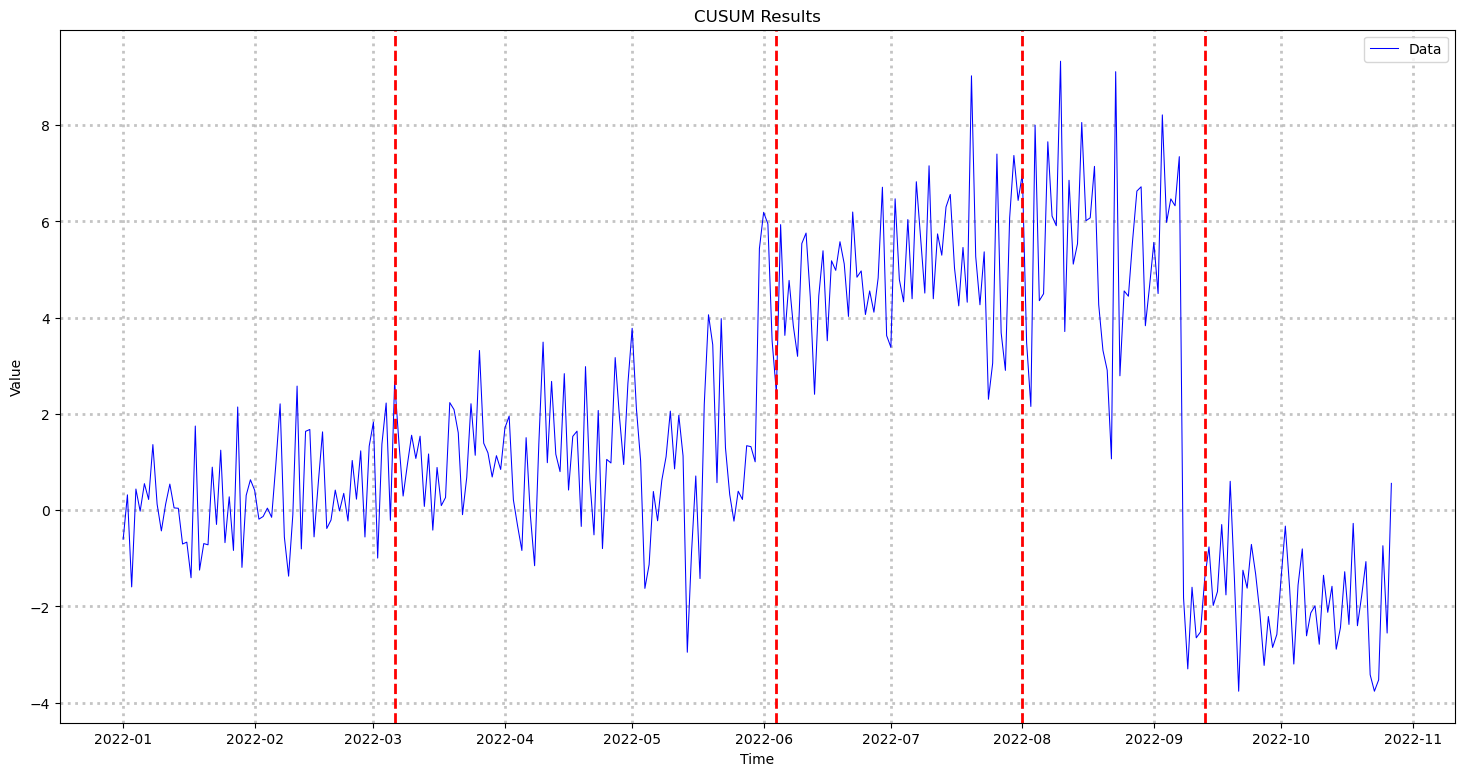

{'value1': [64    2022-03-06
  154   2022-06-04
  212   2022-08-01
  255   2022-09-13
  Name: date, dtype: datetime64[ns]]}

In [25]:
test.plot_cusum(a, ['value1'])

2024-08-07 10:51:41.281 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=16.368181)
2024-08-07 10:51:41.310 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=11.981057)
2024-08-07 10:51:41.344 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=18.893876)
2024-08-07 10:51:41.375 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=43.929834)


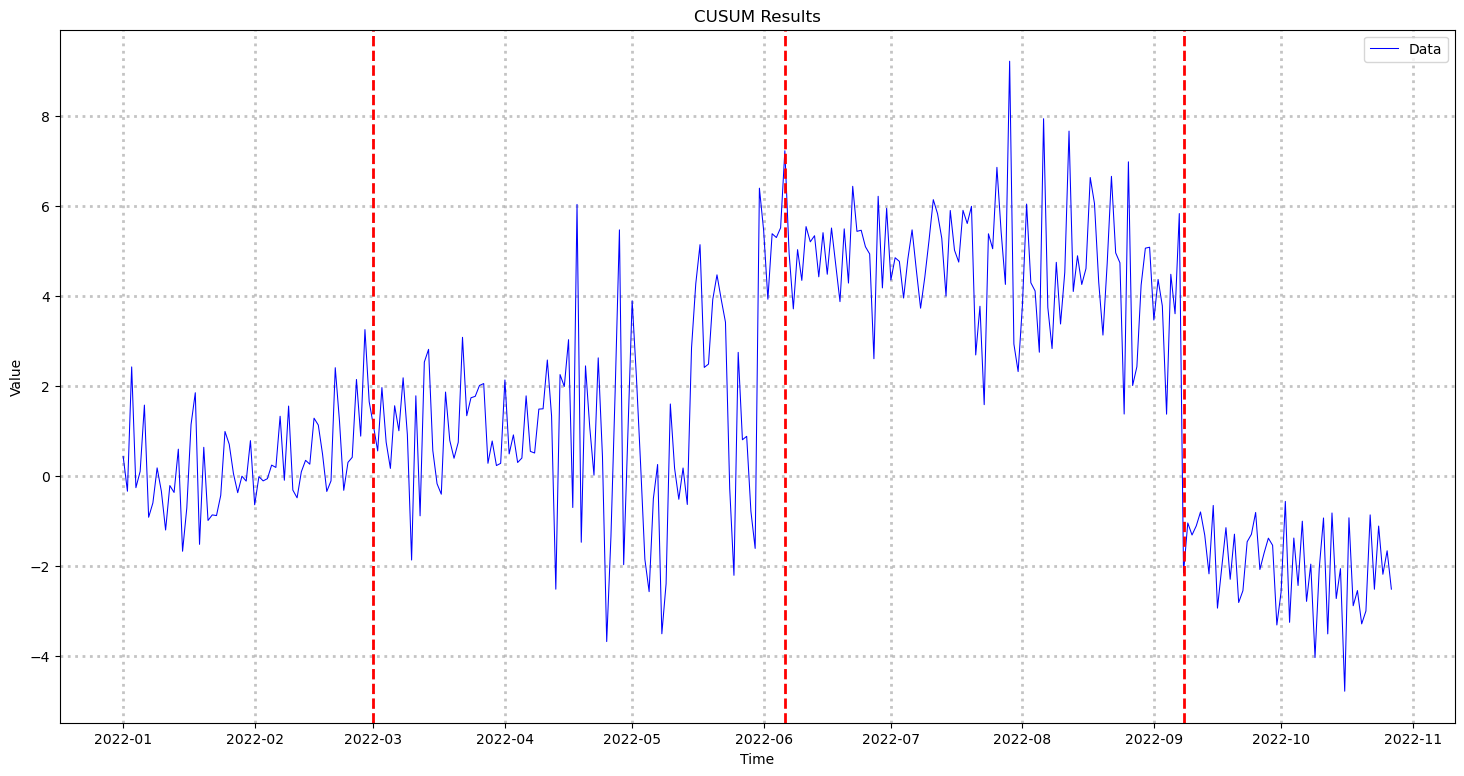

{'value2': [59    2022-03-01
  156   2022-06-06
  250   2022-09-08
  Name: date, dtype: datetime64[ns]]}

In [26]:
test.plot_cusum(a, ['value2'])

### Conclusion

The CusumDetector class effectively facilitates change point detection in time series data using the Cumulative Sum (CUSUM) method. Designed with flexibility and robustness in mind, this class can handle multiple metrics and large datasets, making it a valuable tool for various applications such as anomaly detection, trend analysis, and quality control.

#### Key Features:
- Warm-up Period: A configurable warm-up period allows the class to stabilize initial parameter estimation, ensuring reliable change point detection.
- Probability Limit: The class uses a threshold probability to detect significant changes, balancing sensitivity and specificity according to user-defined criteria.
- Multiple Metric Handling: The class processes each metric independently, allowing for separate change point detection across different variables in a dataset.
- Plotting Capabilities: It provides visualization of time series data with detected change points, facilitating intuitive analysis and interpretation of results.

#### Methods:
- predict_next(y): Predicts the probability of a change point and whether a change point is detected for the next observation.
- extract_prob_checkpoint(y): Processes the entire series to extract probabilities and change points.
- plot_checkpoint(df, column): Plots the time series and marks the detected change points.
- process_single_column(df, column): Processes a single column in a DataFrame to detect and plot change points.
- plot_cusum(df, columns): Processes multiple columns in a DataFrame to detect and plot change points.


The CusumDetector class, with its comprehensive approach to change point detection and analysis, provides a powerful framework for monitoring and understanding time series data. Its modular design and configurable parameters make it adaptable to various scenarios and datasets, ensuring its utility across multiple domains and applications.